In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

import sys
import os
sys.path.append(os.path.join(os.getcwd(), 'src'))

from data_preprocessing_sequence import download_and_load_data, preprocess_data, create_text_sequences
from model_sequence import EnhancedLSTMModel
from training_sequence import train_sequence_model, sequence_collate_fn
from evaluation_sequence import evaluate_sequence_model, test_sequence_predictions
from rouge_score import rouge_scorer


In [4]:

# Загрузка и предобработка данных
print("Загрузка данных...")
url = "http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip"
tweets_df = download_and_load_data(url)

print("Предобработка данных...")
clean_df, tokenizer = preprocess_data(tweets_df, save_path='./data/')

print("Создание последовательностей для автодополнения...")
clean_df['input_ids'] = clean_df['input_ids'].apply(
    lambda x: [int(i) for i in x.strip('[]').split(',')] if isinstance(x, str) else x
)

# Создаем последовательности: 75% как вход, 25% как цель
X_data, y_data = create_text_sequences(clean_df['input_ids'].tolist(), train_ratio=0.75)

print(f"Создано {len(X_data)} примеров")
print(f"Длина входа: {len(X_data[0])}, длина цели: {len(y_data[0])}")

# Разделение данных
X_train, X_temp, y_train, y_temp = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42, shuffle=True
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True
)

print(f"Размеры выборок:")
print(f"Train: {len(X_train)} примеров")
print(f"Validation: {len(X_val)} примеров")
print(f"Test: {len(X_test)} примеров")

# Сохранение разделенных данных
train_df = pd.DataFrame({'X': X_train, 'y': y_train})
train_df.to_csv('./data/train_sequence_dataset.csv', index=False)

val_df = pd.DataFrame({'X': X_val, 'y': y_val})
val_df.to_csv('./data/validation_sequence_dataset.csv', index=False)

test_df = pd.DataFrame({'X': X_test, 'y': y_test})
test_df.to_csv('./data/test_sequence_dataset.csv', index=False)

# Создание DataLoader'ов
batch_size = 32
pad_token_id = 0

train_loader = DataLoader(
    list(zip(X_train, y_train)),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=lambda batch: sequence_collate_fn(batch, pad_token_id)
)

val_loader = DataLoader(
    list(zip(X_val, y_val)),
    batch_size=batch_size,
    shuffle=False,
    collate_fn=lambda batch: sequence_collate_fn(batch, pad_token_id)
)

test_loader = DataLoader(
    list(zip(X_test, y_test)),
    batch_size=batch_size,
    shuffle=False,
    collate_fn=lambda batch: sequence_collate_fn(batch, pad_token_id)
)


Загрузка данных...
Предобработка данных...
Создание последовательностей для автодополнения...
Отфильтровано 1072316 проблемных последовательностей
Создано 527684 примеров
Длина входа: 15, длина цели: 6
Размеры выборок:
Train: 422147 примеров
Validation: 52768 примеров
Test: 52769 примеров


In [5]:

# Инициализация модели
print("Инициализация модели...")
model = EnhancedLSTMModel(
    vocab_size=30522,
    embedding_dim=128,
    hidden_dim=128,
    num_layers=2,
    pad_token_id=0,
    dropout=0.5,
    use_layer_norm=True,
    use_mean_pooling=False
)


Инициализация модели...


Начало обучения...
Epoch 1, Batch 0, Loss: 10.3275, Accuracy: 0.0000
Epoch 1, Batch 50, Loss: 9.7039, Accuracy: 0.1531
Epoch 1, Batch 100, Loss: 9.4884, Accuracy: 0.1561
Epoch 1, Batch 150, Loss: 8.5437, Accuracy: 0.1455
Epoch 1, Batch 200, Loss: 8.4239, Accuracy: 0.1481
Epoch 1, Batch 250, Loss: 8.4750, Accuracy: 0.1475
Epoch 1, Batch 300, Loss: 8.0998, Accuracy: 0.1538
Epoch 1, Batch 350, Loss: 8.0142, Accuracy: 0.1553
Epoch 1, Batch 400, Loss: 7.4460, Accuracy: 0.1495
Epoch 1, Batch 450, Loss: 6.8490, Accuracy: 0.1546
Epoch 1, Batch 500, Loss: 6.9531, Accuracy: 0.1602
Epoch 1, Batch 550, Loss: 6.9733, Accuracy: 0.1514
Epoch 1, Batch 600, Loss: 6.8115, Accuracy: 0.1596
Epoch 1, Batch 650, Loss: 6.4553, Accuracy: 0.1951
Epoch 1, Batch 700, Loss: 6.2436, Accuracy: 0.1801
Epoch 1, Batch 750, Loss: 6.6985, Accuracy: 0.1691
Epoch 1, Batch 800, Loss: 6.2778, Accuracy: 0.2146
Epoch 1, Batch 850, Loss: 6.2874, Accuracy: 0.2055
Epoch 1, Batch 900, Loss: 6.8105, Accuracy: 0.1607
Epoch 1, Batch

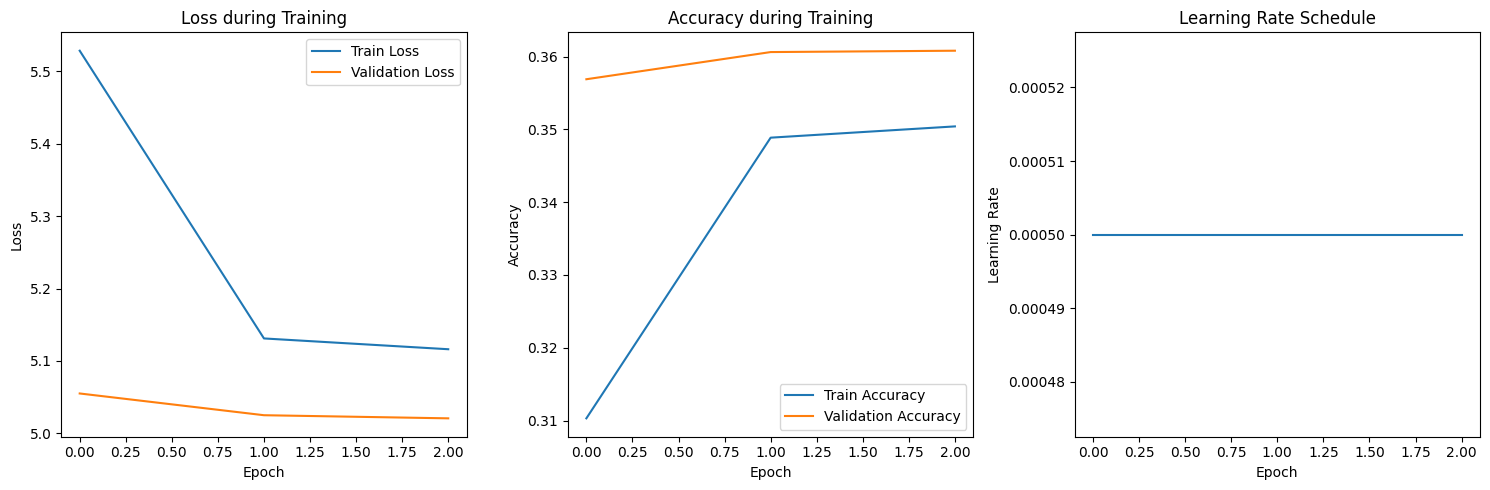

In [3]:

# Обучение модели
print("Начало обучения...")
model, train_losses, val_losses, train_accuracies, val_accuracies, learning_rates = train_sequence_model(
    model, train_loader, val_loader,
    num_epochs=3,
    learning_rate=0.0005,
    max_grad_norm=1.0,
    weight_decay=1e-4,
    model_save_path='./models/sequence_model.pth'
)

# Визуализация результатов обучения
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss during Training')

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy during Training')

plt.subplot(1, 3, 3)
plt.plot(learning_rates)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.tight_layout()
plt.savefig('./results/sequence_training_curves.png')
plt.show()

In [4]:
# Сохранение финальной модели
os.makedirs('./models', exist_ok=True)
torch.save(model.state_dict(), './models/final_sequence_model.pth')

In [5]:
# Проверка параметров сохраненной модели
checkpoint = torch.load('./models/final_sequence_model.pth', map_location='cpu')
print("Ключи в state_dict:")
for key in checkpoint.keys():
    print(f"{key}: {checkpoint[key].shape}")

# Определите hidden_dim по размеру весов
# Например, если lstm.weight_ih_l0 имеет размер [512, 128], то:
# hidden_dim = 128 (так как 512 = 4 * hidden_dim)

Ключи в state_dict:
embedding.weight: torch.Size([30522, 128])
lstm.weight_ih_l0: torch.Size([512, 128])
lstm.weight_hh_l0: torch.Size([512, 128])
lstm.bias_ih_l0: torch.Size([512])
lstm.bias_hh_l0: torch.Size([512])
lstm.weight_ih_l1: torch.Size([512, 128])
lstm.weight_hh_l1: torch.Size([512, 128])
lstm.bias_ih_l1: torch.Size([512])
lstm.bias_hh_l1: torch.Size([512])
layer_norm.weight: torch.Size([128])
layer_norm.bias: torch.Size([128])
fc.weight: torch.Size([30522, 128])
fc.bias: torch.Size([30522])


In [6]:

# Тестирование модели
print("Тестирование модели...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model = EnhancedLSTMModel(
    vocab_size=30522,
    embedding_dim=128,
    hidden_dim=128,
    num_layers=2,
    pad_token_id=0,
    dropout=0.5,
    use_layer_norm=True,
    use_mean_pooling=False
)
best_model.load_state_dict(torch.load('./models/final_sequence_model.pth'))
best_model.to(device)

# Оценка с ROUGE метриками
rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], use_stemmer=True)
metrics, all_predictions, all_targets = evaluate_sequence_model(
    best_model, test_loader, tokenizer, rouge_scorer_obj, device
)

print("\nРЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

# Тестирование конкретных предсказаний
test_sequence_predictions(best_model, list(zip(X_test, y_test)), tokenizer, 
                         num_examples=5, device=device)

print("Все этапы завершены успешно!")

Тестирование модели...

РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ:
rouge1: 0.0521
rouge2: 0.0036
total_samples: 52769.0000

Пример 1:
Входной текст: 'ok why do i feel like u r breaking up with us any moment now i am waiting u break'
Целевой текст: 'out in song its officially over'
Предсказанный текст: 'break long go and'
ROUGE-1: 0.0000
ROUGE-2: 0.0000
--------------------------------------------------------------------------------

Пример 2:
Входной текст: 'so if i go to ur concert in greenville sc in julywould u promise to bring me up on stage'
Целевой текст: 'to sing as song w u seriously'
Предсказанный текст: 'stage myspace wait ones instead stay on is the'
ROUGE-1: 0.0000
ROUGE-2: 0.0000
--------------------------------------------------------------------------------

Пример 3:
Входной текст: 'is off now very sleep and gotta wake up in hours oof goodnight'
Целевой текст: 'dearest twitterees'
Предсказанный текст: 'goodnight ff xx live bad it'
ROUGE-1: 0.0000
ROUGE-2: 0.0000
-------------------------